# <a id="contents"></a> Table of Contents

1. [Import Libraries](#imports)
2. [Standardizing Data](#standardizing-data)
3. [Loading Position Data](#loading-data)
4. [Descriptive Statistics and Visualization](#descriptive-stats)
   - 4.1 [Descriptive Statistics Calculation](#descriptive-stats-calc)
   - 4.2 [Displaying Descriptive Statistics as Heatmap](#descriptive-stats-heatmap)
5. [Distribution and Box Plot Visualization](#distribution-and-box-plot)
6. [Correlation Heatmaps](#correlation-heatmaps)
7. [Baseline Models](#baseline-models)
   - 7.1 [Defense PCA Baseline](#baseline-models-defense)
   - 7.2 [Midfielder PCA Baseline](#baseline-models-midfielder)
   - 7.3 [Goalkeeper PCA Baseline](#baseline-models-goalkeeper)


<a id="imports"></a>

## <div class='section'>Section 1: Import Libraries</div>


In [40]:
import itertools
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

<a id="standardizing-data"></a>

## <div class='section'>Section 2: Standardizing Data</div>

[Return to contents](#contents)

Here, we define a `standardize` function that will be used to scale and standardize the data to ensure that each feature contributes equally to any subsequent analysis so that we can avoid biases due to differences in scale.


In [41]:
def standardize(df):
    numeric_columns = df.select_dtypes(include='number').columns
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df[numeric_columns])

    # Convert standardized data back to a dataframe for PCA
    standardized_df = pd.DataFrame(standardized_data, columns=numeric_columns)
    return standardized_df


<a id="loading-data"></a>

## <div class='section'>Section 3: Loading Position Data</div>

[Return to contents](#contents)

Here, we load and `standardize` data from CSV files for each position, then organize them in a dictionary.


In [42]:
# Make dataframes
goalkeepers = standardize(pd.read_csv("stats/GK_relevant_stats.csv"))
defenders = standardize(pd.read_csv("stats/DF_relevant_stats.csv"))
midfielders = standardize(pd.read_csv("stats/MF_relevant_stats.csv"))
forwards = standardize(pd.read_csv("stats/FW_relevant_stats.csv"))

# Dictionary of dataframes for each position
dataframes = {
    'Goalkeepers': goalkeepers, 
    'Defenders': defenders, 
    'Midfielders': midfielders, 
    'Forwards': forwards
}

<a id="descriptive-stats"></a>

## <div class='section'>Section 4: Descriptive Statistics and Visualization</div>

[Return to contents](#contents)

Here, we calculate and visualize descriptive statistics for each position dataset which will provide insights into the central tendency, spread, and range of values for each feature in the dataset.


<a id="descriptive-stats-calc"></a>

#### <div class='sub-section'>4.1: Descriptive Statistics Calculation</div>

Here, we calculate the mean, standard deviation, median, min, max, and range of each numeric feature in the dataset.




In [43]:
def descriptive_stats(df):
    numeric_df = df.select_dtypes(include='number')
    stats = numeric_df.describe().T  # Transpose for readability
    stats['median'] = numeric_df.median()  # Add median
    stats['range'] = stats['max'] - stats['min']  # Calculate range
    return stats[['mean', 'std', 'median', 'min', 'max', 'range']]


<a id="descriptive-stats-heatmap"></a>

#### <div class='sub-section'>4.2: Displaying Descriptive Statistics as Heatmap</div>

Here, we create heatmaps to visualize the descriptive statistics for each feature and to help us easily spot outliers, patterns, and distributions across different features.

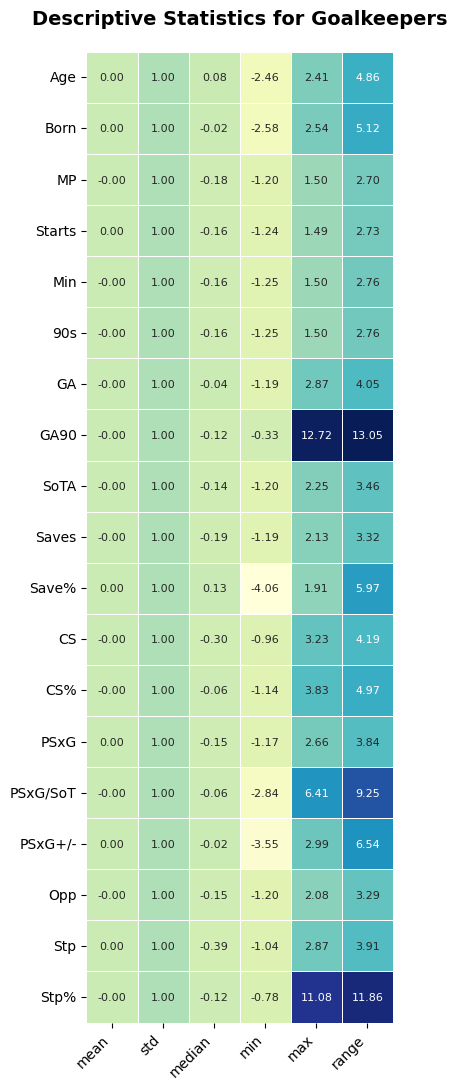

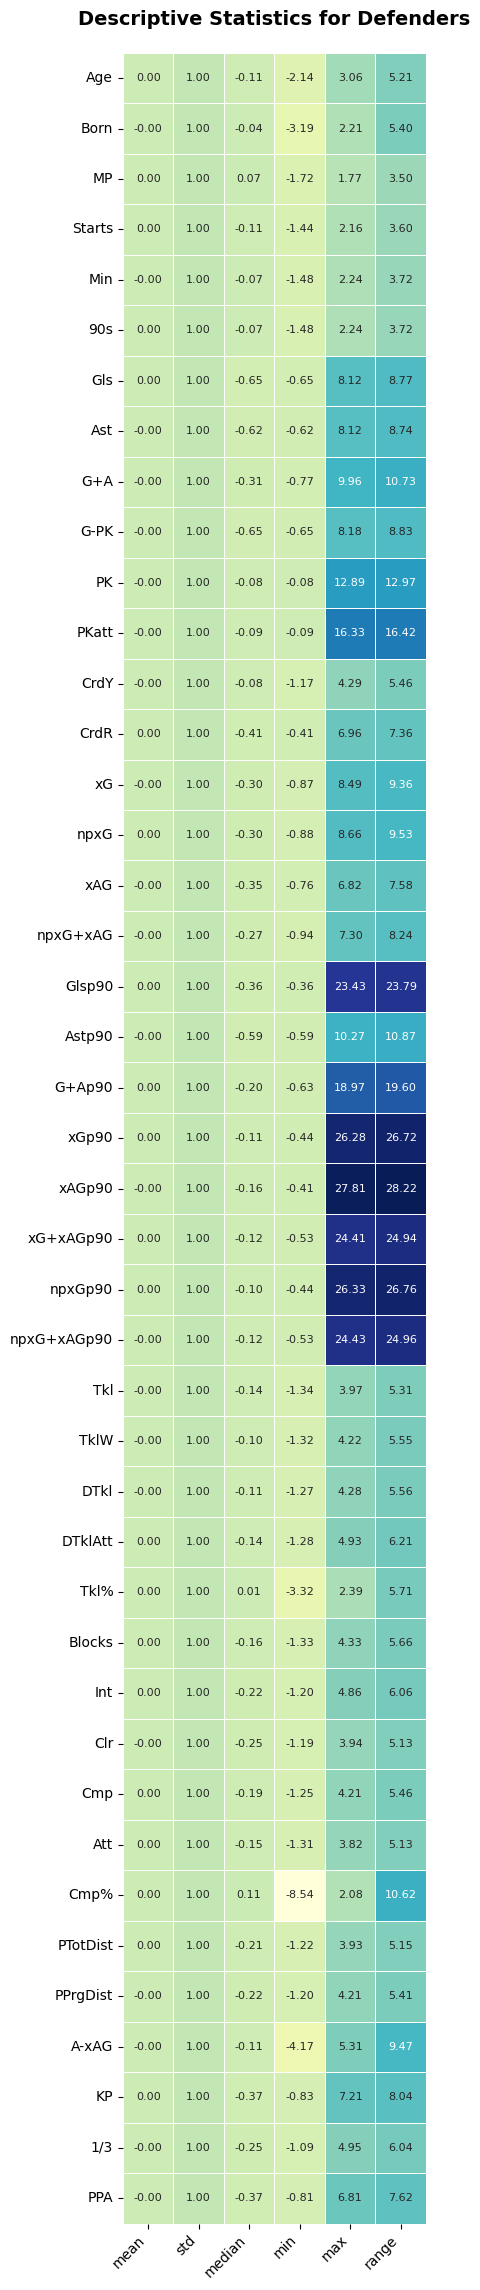

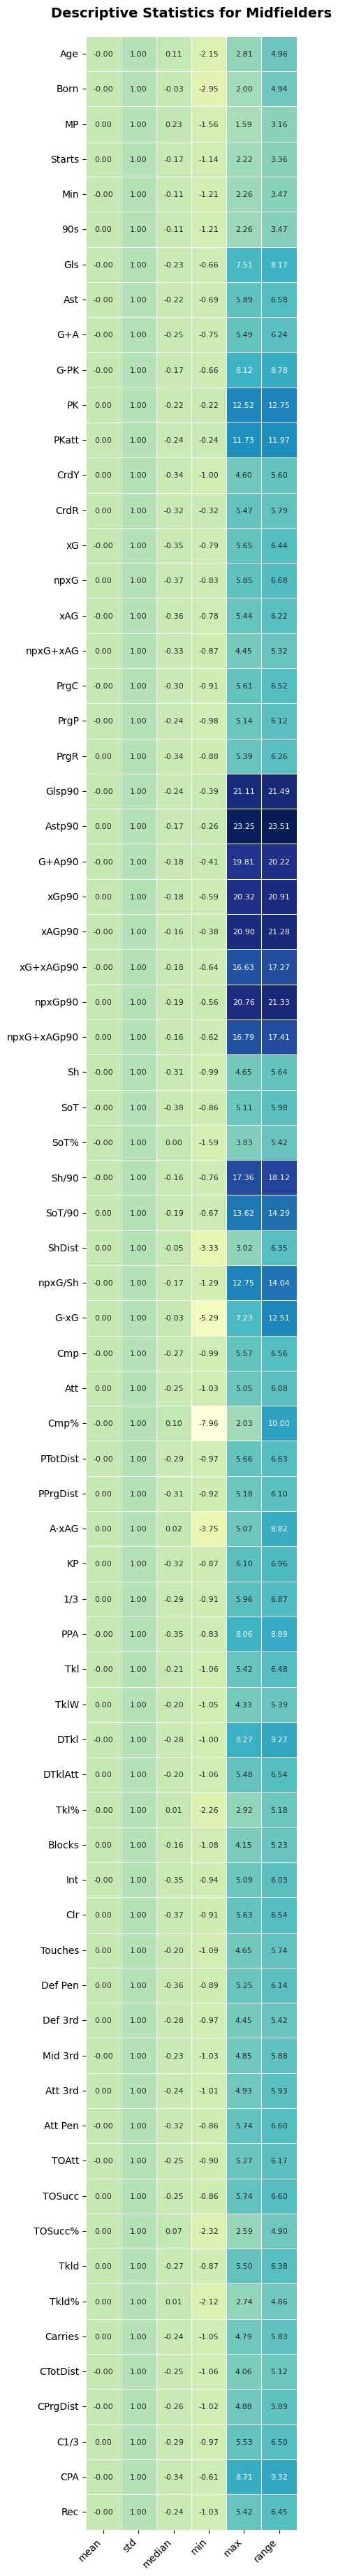

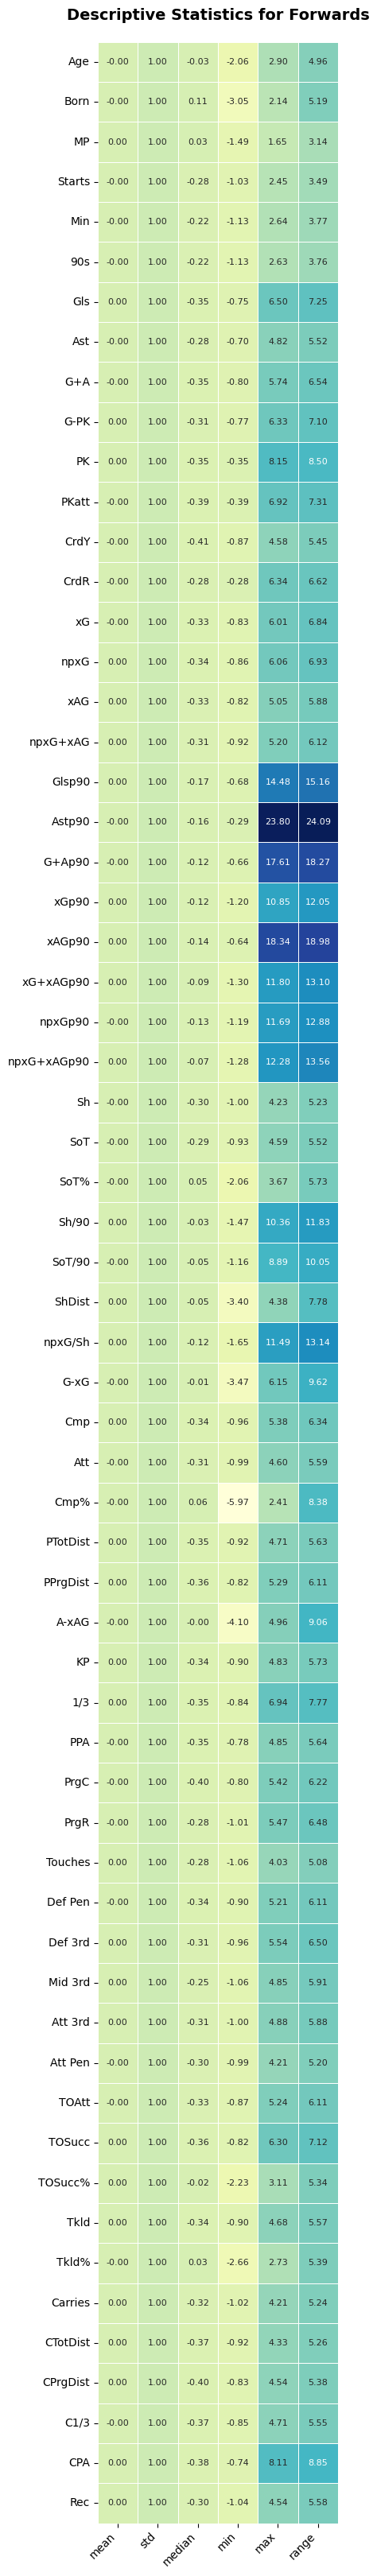

In [44]:
def display_heatmap(stats, title):
    fig, ax = plt.subplots(figsize=(12, len(stats) * 0.5 + 1.5))
    sns.heatmap(stats, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False, linewidths=.5, 
                annot_kws={"size": 8}, ax=ax, square=True)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.title(title, fontweight="bold", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()


# generating and displaying heatmap tables for each position's statistics
for position, df in dataframes.items():
    stats = descriptive_stats(df)
    display_heatmap(stats, f"Descriptive Statistics for {position}")


<a id="distribution-and-box-plot-visualization"></a>

## <div class='section'>Section 5: Distribution and Box Plot Visualization</div>

[Return to contents](#contents)

Here, we generate histograms and box plots for each feature to show the distribution and identify potential outliers. The histograms provide insight into how data points are distributed while box plots reveal central tendencies and variability. The histograms and box plots are then saved as PNG files in the 'plots' folder


In [45]:
def plot_and_save_plots(df, position, stats):
    for stat in stats:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        label = stat_labels.get(stat, stat)

        # histogram
        sns.histplot(df[stat].dropna(), kde=True, ax=axes[0], color="skyblue")
        axes[0].set_title(f'{label} Distribution for {position}')
        axes[0].set_xlabel(label)
        axes[0].set_ylabel('Frequency')

        # boxplot
        sns.boxplot(x=df[stat].dropna(), ax=axes[1], color="lightgreen")
        axes[1].set_title(f'{label} Boxplot for {position}')
        axes[1].set_xlabel(label)

        plt.tight_layout()

        # saving plots
        filename = f"plots/{position}_{stat}_EDA.png".replace(" ", "_")
        plt.savefig(filename, format='png', dpi=300)
        plt.close(fig)

# generating and saving plots for each position
for position, df in dataframes.items():
    print(f"Saving plots for {position}...")
    # plot_and_save_plots(df, position, basic_stats[position])

print("All plots have been saved as PNG files.")


Saving plots for Goalkeepers...
Saving plots for Defenders...
Saving plots for Midfielders...
Saving plots for Forwards...
All plots have been saved as PNG files.


<a id="correlation-heatmaps"></a>

## <div class='section'>Section 6: Correlation Heatmaps</div>

[Return to contents](#contents)

Finally, we create correlation heatmaps to explore any positive or negative relationships between features that may be useful for further analysis or model building.


In [46]:
def save_correlation_heatmap(df, position, stats):
    df_filtered = df[stats]
    corr = df_filtered.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
                linewidths=0.5, annot_kws={"size": 8})
    plt.title(f'Correlation Heatmap for {position}', fontweight='bold', fontsize=14)
    plt.tight_layout()
    filename = f"heatmap/{position}_correlation_heatmap.png".replace(" ", "_")
    plt.savefig(filename, format='png', dpi=300)
    plt.close()

# generating and saving correlation heatmaps for each position
for position, df in dataframes.items():
    print(f"Generating correlation heatmap for {position}...")
    # save_correlation_heatmap(df, position, basic_stats[position])

print("All correlation heatmaps have been saved as PNG files.")


Generating correlation heatmap for Goalkeepers...
Generating correlation heatmap for Defenders...
Generating correlation heatmap for Midfielders...
Generating correlation heatmap for Forwards...
All correlation heatmaps have been saved as PNG files.


<a id="baseline-models"></a>

## <div class='section'>Section 7: Baseline Models</div>

[Return to contents](#contents)

Here we are creating the baseline PCA models for each position.


<a id="baseline-models-defense"></a>

#### <div class='sub-section'>7.1: Defense PCA Baseline</div>


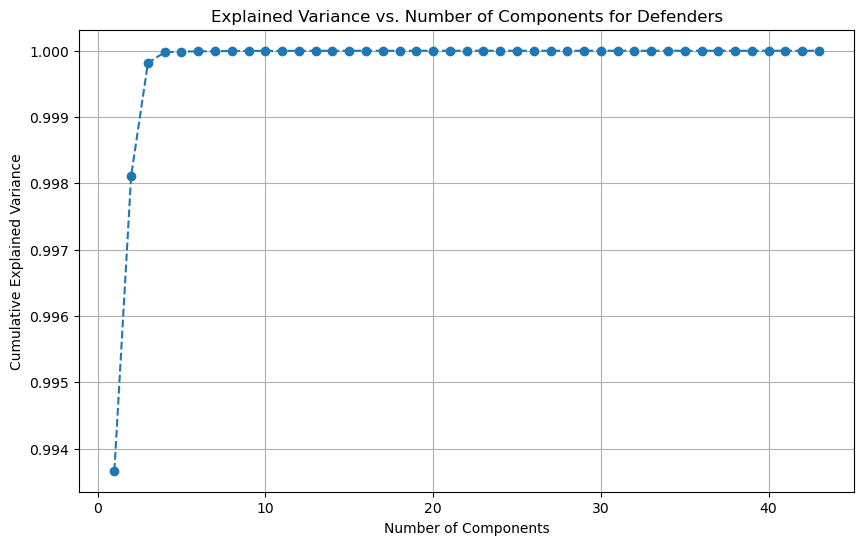

In [47]:
from sklearn.decomposition import PCA

defenders = pd.read_csv("stats/DF_relevant_stats.csv")
defender = defenders.select_dtypes(include=[np.number]).dropna()

pca = PCA()
pca_data = pca.fit_transform(defender)


explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Defenders')
plt.grid()
plt.show()


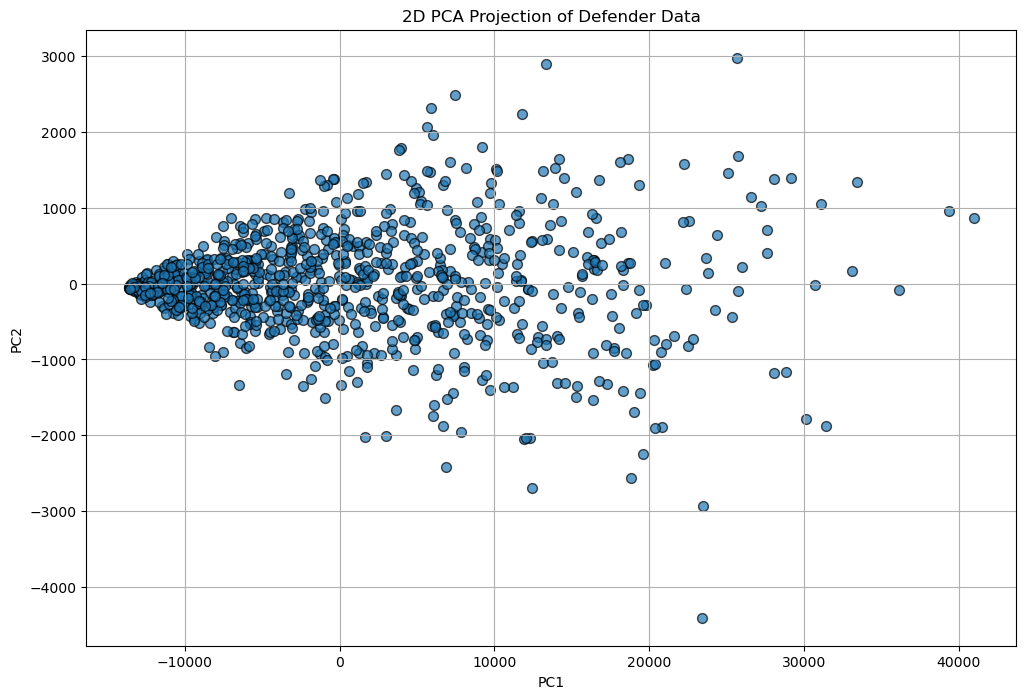

In [48]:
defenders = pd.read_csv("stats/DF_relevant_stats.csv")
defenders_numeric = defenders.select_dtypes(include=[np.number]).dropna()

pca = PCA(n_components=2)
defenders_pca = pca.fit_transform(defenders_numeric)


plt.figure(figsize=(12, 8))
plt.scatter(defenders_pca[:, 0], defenders_pca[:, 1], alpha=0.7, edgecolors='k', s=50)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Defender Data")
plt.grid()
plt.show()

In [49]:
features = defenders_numeric.columns
pc_loadings = pca.components_
pc1_pc2_loadings = pd.DataFrame(pc_loadings[:2], columns=features, index=['PC1', 'PC2']).T

print("\nTop features contributing to PC1:")
print(pc1_pc2_loadings['PC1'].sort_values(ascending=False).head(5))

print("\nTop features contributing to PC2:")
print(pc1_pc2_loadings['PC1'].sort_values(ascending=False).head(5))


Top features contributing to PC1:
PTotDist    0.936
PPrgDist    0.337
Min         0.075
Att         0.058
Cmp         0.051
Name: PC1, dtype: float64

Top features contributing to PC2:
PTotDist    0.936
PPrgDist    0.337
Min         0.075
Att         0.058
Cmp         0.051
Name: PC1, dtype: float64


In [50]:
defenders = defenders.loc[defenders_numeric.index]

defenders['PC1'] = defenders_pca[:, 0]
defenders['PC2'] = defenders_pca[:, 1]

print("Top 10 defenders based on PC1:")
print(defenders[['Player', 'PC1']].sort_values(by='PC1', ascending=False).head(10))

print("\nTop 10 defenders based on PC2:")
print(defenders[['Player', 'PC2']].sort_values(by='PC2', ascending=False).head(10))



Top 10 defenders based on PC1:
                 Player        PC1
567          Lewis Dunk  40991.445
969     Virgil van Dijk  39393.185
740  Nico Schlotterbeck  36163.426
218               Dante  33454.396
978      William Saliba  33076.693
855          Rúben Dias  31409.403
200     Cristian Romero  31084.421
973      Waldemar Anton  30714.730
505        Jules Koundé  30127.453
203         Daley Blind  29136.880

Top 10 defenders based on PC2:
               Player       PC2
323   Florian Lejeune  2977.231
770    Óscar Mingueza  2900.749
972   Vladimír Coufal  2487.185
247        Diego Rico  2316.804
714           Murillo  2235.453
339    Gabriele Zappa  2057.754
959  Valentin Gendrey  1952.057
465  Jonas Föhrenbach  1806.315
426    Javi Hernández  1787.034
502      Juan Miranda  1762.290



<a id="baseline-models-midfielder"></a>

#### <div class='sub-section'>7.2: Midfielder PCA Baseline</div>


In [51]:
# mapping
column_mapping = {
    'Player': 'Player',
    'Nation': 'Nationality',
    'Pos': 'Position',
    'Squad': 'Team',
    'Comp': 'Competition',
    'Age': 'Age',
    'Born': 'Year Born',
    'MP': 'Matches Played',
    'Starts': 'Starts',
    'Min': 'Minutes Played',
    '90s': '90-Minute Increments',
    'Gls': 'Goals',
    'Ast': 'Assists',
    'G+A': 'Goals + Assists',
    'G-PK': 'Goals (Excl. Penalties)',
    'PK': 'Penalty Goals',
    'PKatt': 'Penalty Attempts',
    'CrdY': 'Yellow Cards',
    'CrdR': 'Red Cards',
    'xG': 'Expected Goals',
    'npxG': 'Non-Penalty Expected Goals',
    'xAG': 'Expected Assists',
    'npxG+xAG': 'Expected Non-Penalty Goals + Assists',
    'PrgC': 'Progressive Carries',
    'PrgP': 'Progressive Passes',
    'PrgR': 'Progressive Runs',
    'Glsp90': 'Goals per 90',
    'Astp90': 'Assists per 90',
    'G+Ap90': 'Goals + Assists per 90',
    'xGp90': 'Expected Goals per 90',
    'xAGp90': 'Expected Assists per 90',
    'xG+xAGp90': 'Expected Goals + Assists per 90',
    'npxGp90': 'Non-Penalty Goals per 90',
    'npxG+xAGp90': 'Non-Penalty Goals + Assists per 90',
    'Sh': 'Shots',
    'SoT': 'Shots on Target',
    'SoT%': 'Shots on Target %',
    'Sh/90': 'Shots per 90',
    'SoT/90': 'Shots on Target per 90',
    'ShDist': 'Average Shot Distance',
    'npxG/Sh': 'Non-Penalty xG per Shot',
    'G-xG': 'Goals Minus xG',
    'Cmp': 'Passes Completed',
    'Att': 'Passes Attempted',
    'Cmp%': 'Pass Completion %',
    'PTotDist': 'Total Passing Distance',
    'PPrgDist': 'Progressive Passing Distance',
    'A-xAG': 'Assists Minus xAG',
    'KP': 'Key Passes',
    '1/3': 'Passes into Final Third',
    'PPA': 'Passes into Penalty Area',
    'Tkl': 'Tackles',
    'TklW': 'Tackles Won',
    'DTkl': 'Dribbles Tackled',
    'DTklAtt': 'Dribbles Tackled Attempts',
    'Tkl%': 'Tackle Success %',
    'Blocks': 'Blocks',
    'Int': 'Interceptions',
    'Clr': 'Clearances',
    'Touches': 'Touches',
    'Def Pen': 'Touches in Defensive Penalty Area',
    'Def 3rd': 'Touches in Defensive Third',
    'Mid 3rd': 'Touches in Midfield Third',
    'Att 3rd': 'Touches in Attacking Third',
    'Att Pen': 'Touches in Attacking Penalty Area',
    'TOAtt': 'Take-On Attempts',
    'TOSucc': 'Take-On Successes',
    'TOSucc%': 'Take-On Success %',
    'Tkld': 'Tackled',
    'Tkld%': 'Tackled %',
    'Carries': 'Carries',
    'CTotDist': 'Total Carry Distance',
    'CPrgDist': 'Progressive Carry Distance',
    'C1/3': 'Carries into Final Third',
    'CPA': 'Carries into Penalty Area',
    'Rec': 'Passes Received'
}

midfielders.rename(columns=column_mapping, inplace=True)

midfielders = midfielders.dropna()
pca = PCA().fit(midfielders)
pca_mid = pca.transform(midfielders)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1 

In [52]:
print(f"The number of components is: {pca.n_components_}. ")
print(f"The number of components required to explain 95% of the variance is: {n_components_95}")

The number of components is: 71. 
The number of components required to explain 95% of the variance is: 19


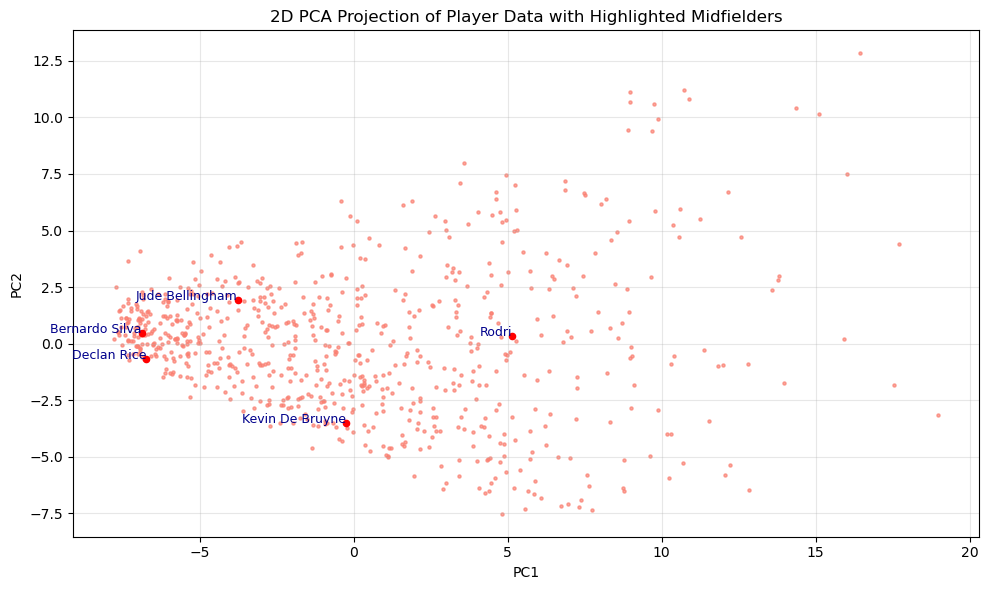

In [53]:
# graphing PCA with names
midfielders_reloaded = pd.read_csv('stats/MF_relevant_stats.csv')

midfielders_cleaned = midfielders_reloaded.dropna().reset_index(drop=True)  
player_names = midfielders_cleaned['Player'] 
famous_midfielders = ['Rodri', 'Jude Bellingham', 'Kevin De Bruyne', 'Bernardo Silva', 'Declan Rice']
famous_indices = player_names[player_names.isin(famous_midfielders)].index

plt.figure(figsize=(10, 6))
plt.scatter(pca_mid[:, 0], pca_mid[:, 1], color='#FA8072', alpha=0.7, s=5, label='All Players')

for i in famous_indices:
    plt.scatter(pca_mid[i, 0], pca_mid[i, 1], color='red', s=20, label=player_names[i])  # Highlight the player
    plt.text(pca_mid[i, 0], pca_mid[i, 1], player_names[i], fontsize=9, ha='right', color='darkblue')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Player Data with Highlighted Midfielders")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

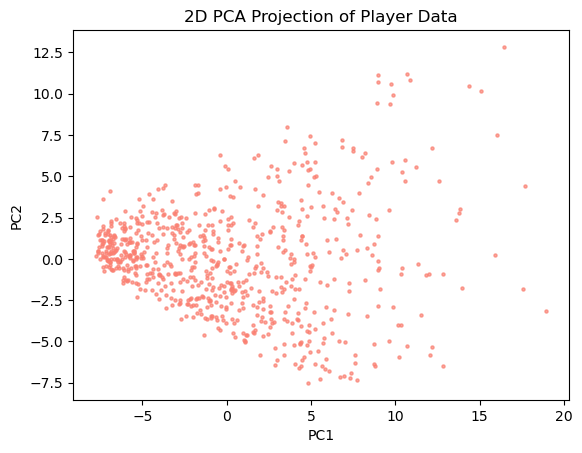

In [54]:
#graphing PCA - issue with there being no names attached to data anymore, hard to call out famous athletes
plt.scatter(pca_mid[:,0], pca_mid[:,1], color='#FA8072', alpha=0.7, s=5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Player Data")
plt.show()

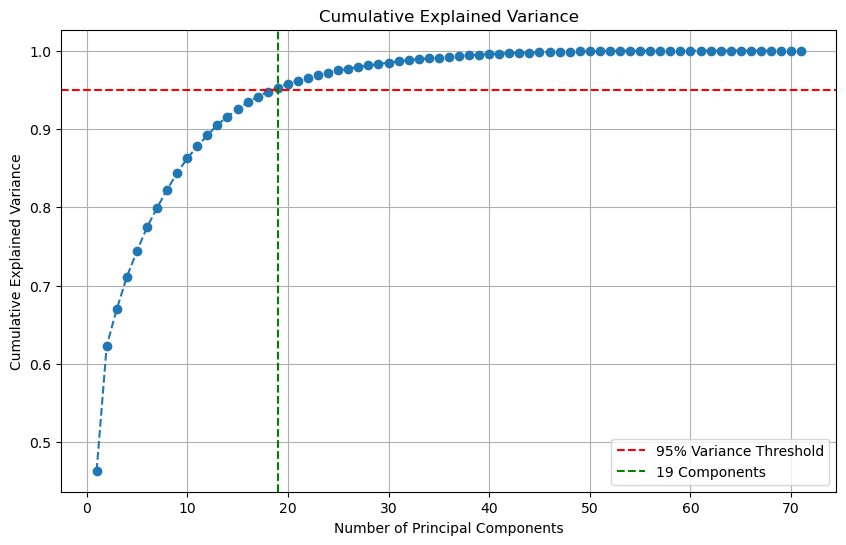

In [55]:
#confidence interval
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} Components')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend(loc='lower right')
plt.grid()
plt.show()

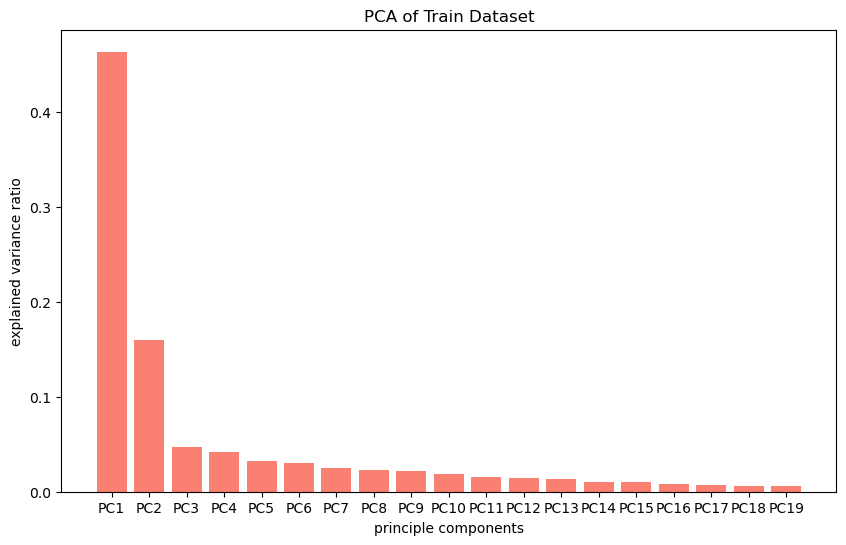

In [56]:
#PCA variance bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(n_components_95), pca.explained_variance_ratio_[:n_components_95], color='#FA8072')
plt.xticks(ticks=range(n_components_95), labels=[f'PC{i}' for i in range(1, n_components_95+1)]);
plt.ylabel('explained variance ratio')
plt.xlabel('principle components')
plt.title('PCA of Train Dataset');
plt.show()

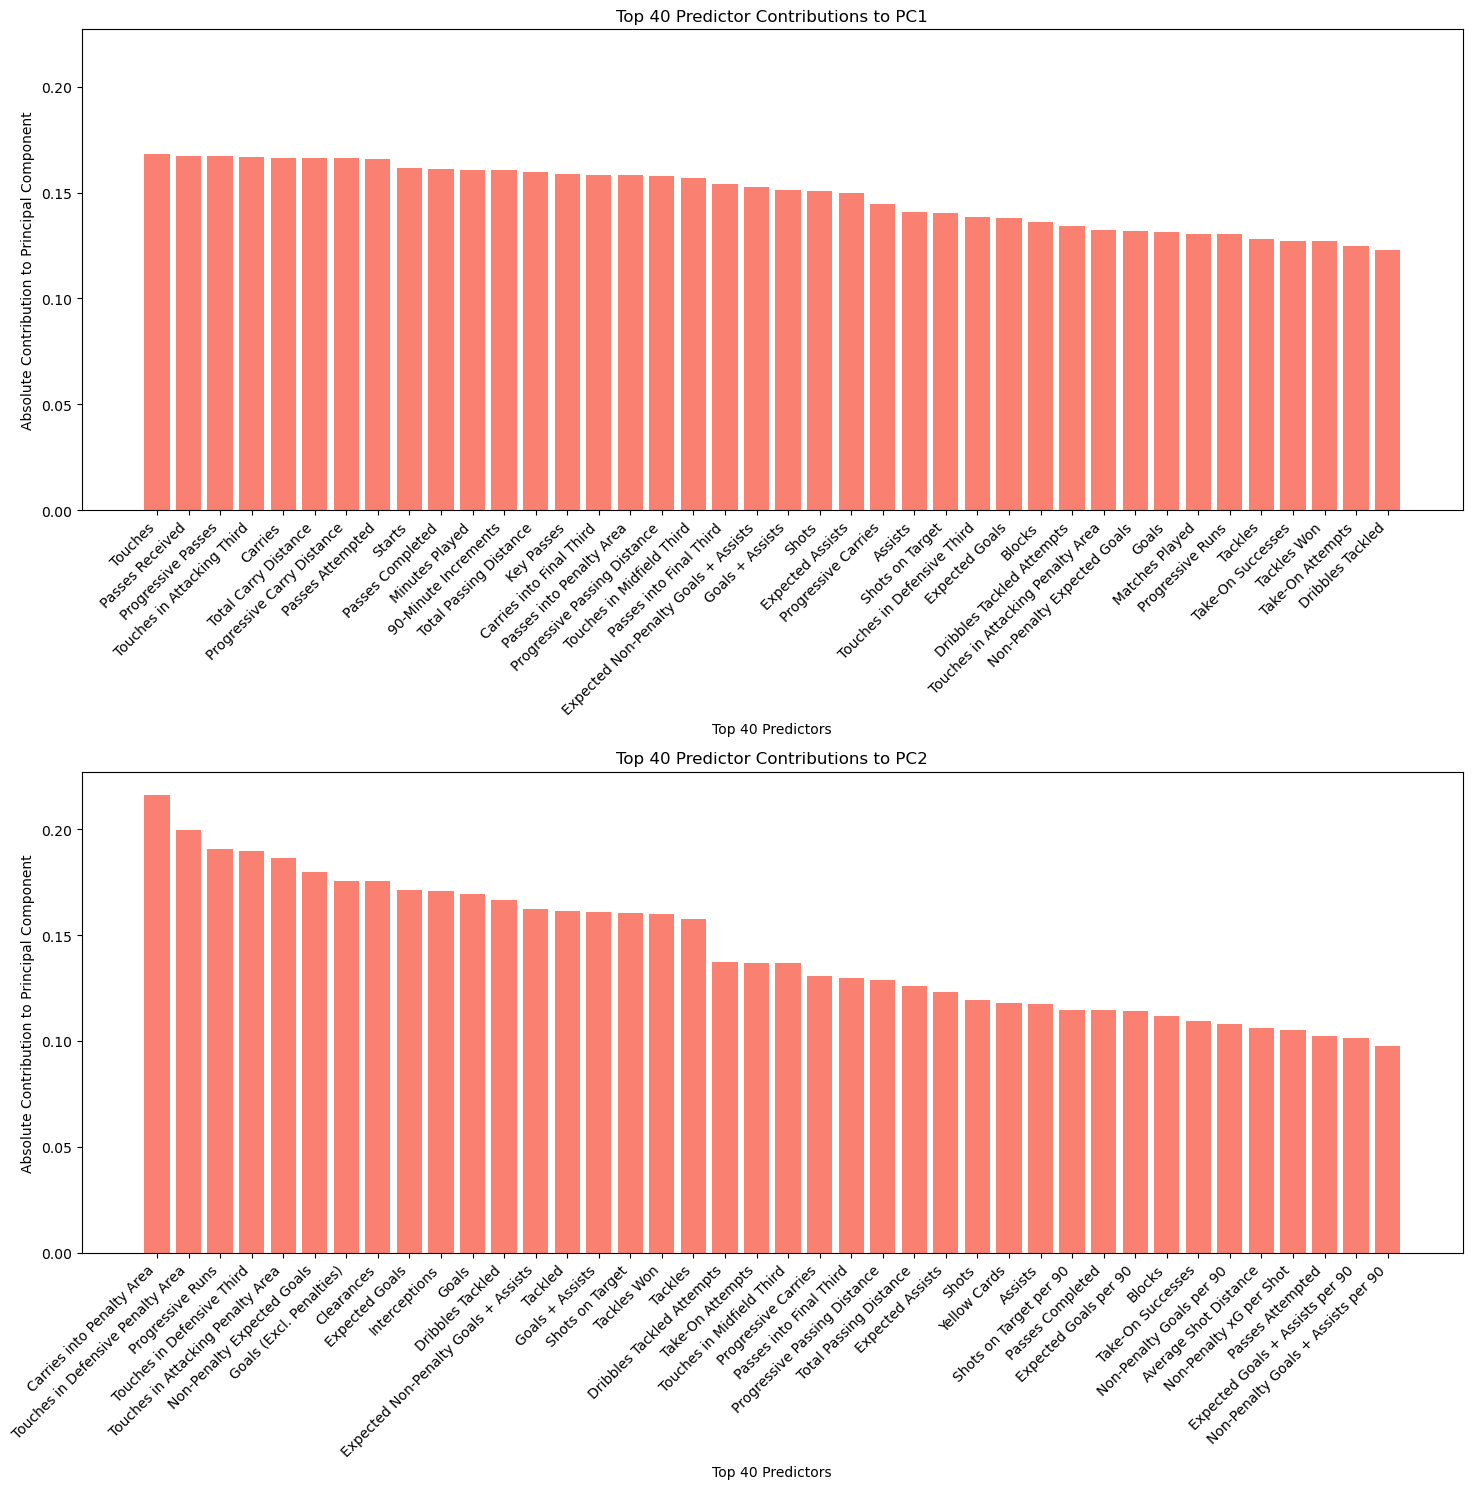

In [57]:
#Predictor Contributing to Components bar graph
num_components = 2

fig, axes = plt.subplots(num_components, 1, figsize=(15, 15), sharey=True)

for i in range(num_components):
    pc_loadings = pca.components_[i]
    absolute_loadings = np.abs(pc_loadings)  
   
    top_indices = np.argsort(absolute_loadings)[-40:][::-1]  
    top_features = midfielders.columns[top_indices]  
    top_contributions = absolute_loadings[top_indices]  

    axes[i].bar(top_features, top_contributions, color='#FA8072')
    axes[i].set_title(f'Top 40 Predictor Contributions to PC{i + 1}')
    axes[i].set_xticks(range(len(top_features)))
    axes[i].set_xticklabels(top_features, rotation=45, ha='right')
    axes[i].set_xlabel('Top 40 Predictors')
    axes[i].set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="baseline-models-goalkeeper"></a>

#### <div class='sub-section'>7.3: Goalkeeper PCA Baseline</div>

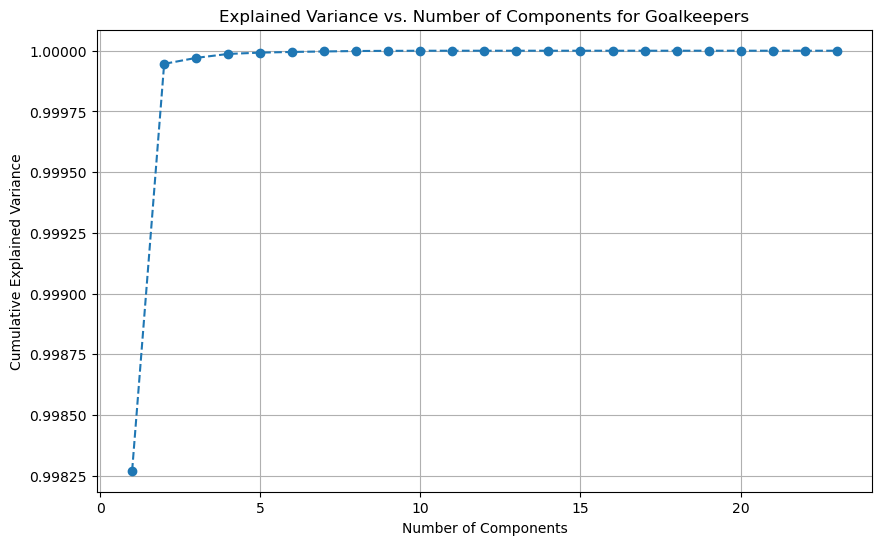

In [76]:
from sklearn.decomposition import PCA

goalkeepers_numeric = goalkeepers_df.select_dtypes(include=[np.number]).dropna()

pca = PCA()
pca_data = pca.fit_transform(goalkeepers_numeric)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Goalkeepers')
plt.grid()
plt.show()



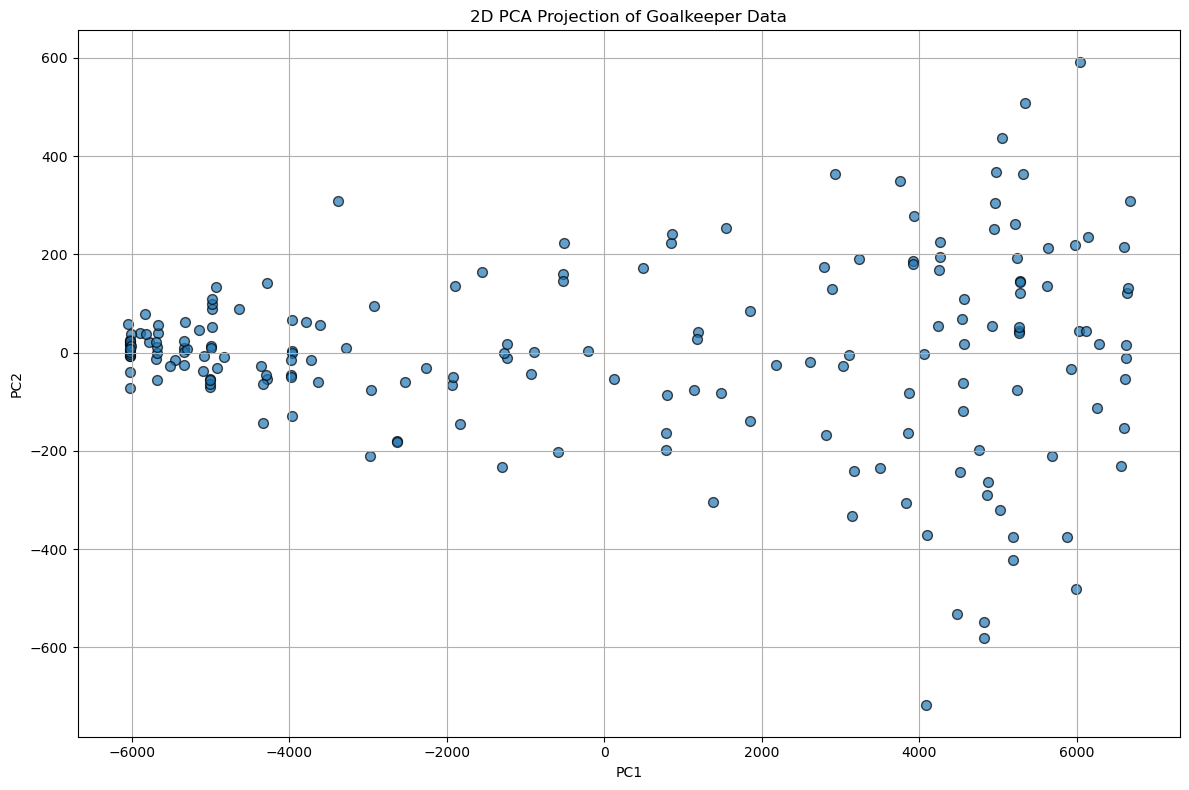

In [77]:

pca_2d = PCA(n_components=2)
goalkeepers_pca = pca_2d.fit_transform(goalkeepers_numeric)

plt.figure(figsize=(12, 8))
plt.scatter(goalkeepers_pca[:, 0], goalkeepers_pca[:, 1], alpha=0.7, edgecolors='k', s=50)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Goalkeeper Data")
plt.grid()
plt.tight_layout()
plt.show()



In [78]:

features = goalkeepers_numeric.columns
pc_loadings = pca_2d.components_
pc1_pc2_loadings = pd.DataFrame(pc_loadings[:2], columns=features, index=['PC1', 'PC2']).T

print("\nTop features contributing to PC1:")
print(pc1_pc2_loadings['PC1'].sort_values(ascending=False).head(5))

print("\nTop features contributing to PC2:")
print(pc1_pc2_loadings['PC2'].sort_values(ascending=False).head(5))




Top features contributing to PC1:
PC1      0.964
Min      0.263
Opp      0.041
SoTA     0.013
Saves    0.009
Name: PC1, dtype: float64

Top features contributing to PC2:
PC2      0.964
Opp      0.241
SoTA     0.078
Saves    0.047
GA       0.032
Name: PC2, dtype: float64


In [82]:

goalkeepers_df = goalkeepers_df.loc[goalkeepers_numeric.index] 
goalkeepers_df['PC1'] = goalkeepers_pca[:, 0]

# the top 10 goalkeepers based on PC1
top_pc1_goalkeepers = goalkeepers_df[['Player', 'PC1']].sort_values(by='PC1', ascending=False).head(10)

print("\nTop 10 goalkeepers based on PC1:")
print(top_pc1_goalkeepers)



Top 10 goalkeepers based on PC1:
                 Player       PC1
18          André Onana  6672.310
94      Jordan Pickford  6642.928
84            Jan Oblak  6641.317
154     Paulo Gazzaniga  6623.283
197   Wladimiro Falcone  6616.648
72    Guglielmo Vicario  6609.182
186     Thomas Kaminski  6596.009
32           Bernd Leno  6593.325
48          David Soria  6553.470
183  Stole Dimitrievski  6282.068


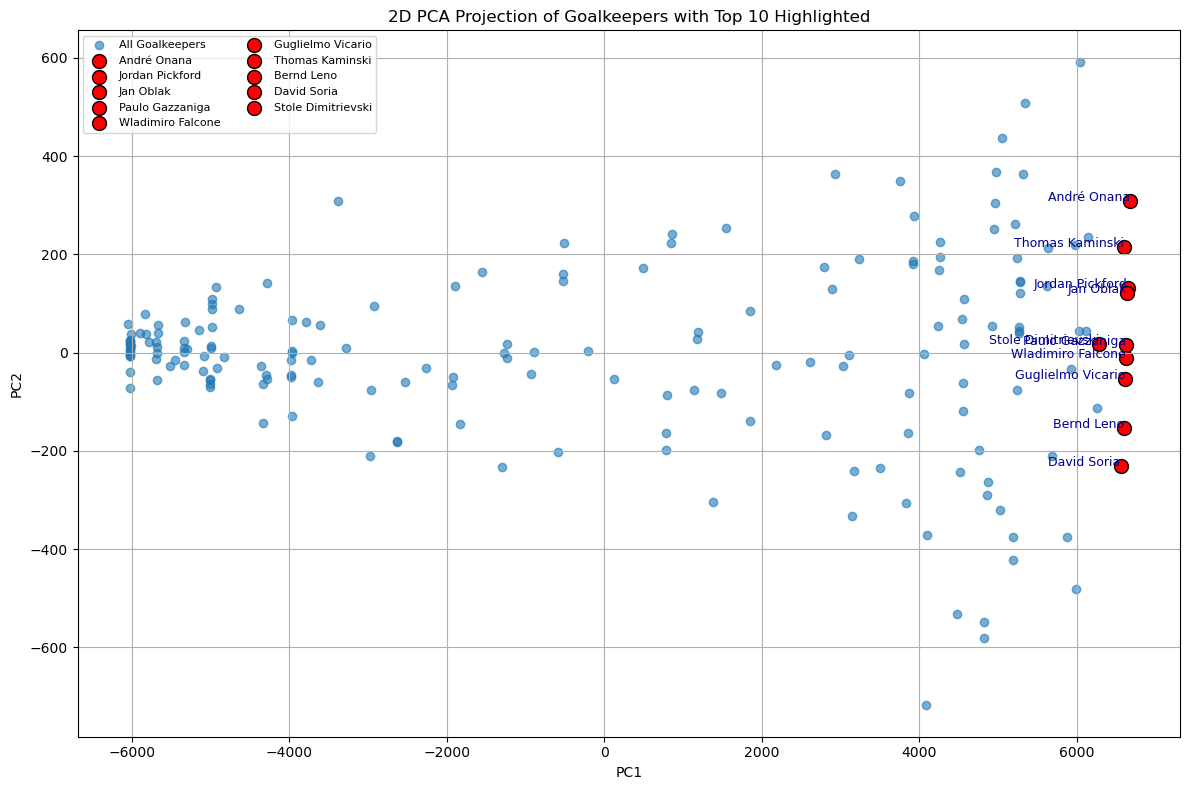

In [83]:
plt.figure(figsize=(12, 8))

plt.scatter(goalkeepers_pca[:, 0], goalkeepers_pca[:, 1], alpha=0.6, label="All Goalkeepers")

for _, row in top_pc1_goalkeepers.iterrows():
    pc1_value = row['PC1']
    pc2_value = goalkeepers_df.loc[goalkeepers_df['Player'] == row['Player'], 'PC2'].values[0]
    plt.scatter(pc1_value, pc2_value, color='red', edgecolor='black', s=100, label=row['Player'])
    plt.text(pc1_value, pc2_value, row['Player'], fontsize=9, ha='right', color='darkblue')
    

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Goalkeepers with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.grid()
plt.tight_layout()
plt.show()